# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, RMSProp, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [88]:
import torch

# прототип функции 
newTensor = torch.FloatTensor(1, 3, 3, 4)
newTensor.fill_(-2)

print ('newTensor:\n', newTensor)
print ('nT.size = ', newTensor.size(), '\n')

newKernal = torch.FloatTensor(3, 3, 3)
newKernal.fill_(3)

print ('newKernal:\n', newKernal)
print ('nK.size = ', newKernal.size(), '\n')

def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):

    
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
        
    convex = torch.FloatTensor ( 1,
                            (x.size(2) - kernel.size(1) + 2*padding[0]) // stride[0] + 1,
                            (x.size(3) - kernel.size(2) + 2*padding[1]) // stride[1] + 1)
    convex.fill_(0)
    
    if (padding[0] != 0):
        zeroes = torch.FloatTensor(x.size(0), x.size(1), padding[0], x.size(3))
        zeroes.fill_(0)
        x = torch.cat((x, zeroes), 2)
        x = torch.cat((zeroes, x), 2)

    if (padding[1] != 0):
        zeroes = torch.FloatTensor(x.size(0), x.size(1), x.size(2), padding[1])
        zeroes.fill_(0)
        x = torch.cat((x, zeroes), 3)
        x = torch.cat((zeroes, x), 3)

    print ('changed x:\n', x)
    print ('convex :\n', convex)
    
    
    for i in range(convex.size(1)):
        for j in range(convex.size(2)):
            a = i * stride[0]
            b = j * stride[1]
            convex[0, i, j] = torch.sum(
            torch.mul(x[:, :, a:(a + kernel.size(1)), b:(b + kernel.size(2))], kernel))
    
    print ('convex2 :\n', convex)
    return convex

            
my_conv2d(newTensor, newKernal, padding=(2, 1), stride=(2, 1))

newTensor:
 tensor([[[[-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.]],

         [[-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.]],

         [[-2., -2., -2., -2.],
          [-2., -2., -2., -2.],
          [-2., -2., -2., -2.]]]])
nT.size =  torch.Size([1, 3, 3, 4]) 

newKernal:
 tensor([[[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]],

        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]],

        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]]])
nK.size =  torch.Size([3, 3, 3]) 

changed x:
 tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0., -2., -2., -2., -2.,  0.],
          [ 0., -2., -2., -2., -2.,  0.],
          [ 0., -2., -2., -2., -2.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
   

tensor([[[ -36.,  -54.,  -54.,  -36.],
         [-108., -162., -162., -108.],
         [ -36.,  -54.,  -54.,  -36.]]])

## Тестируем функцию свертки

### Загружаем картинку 

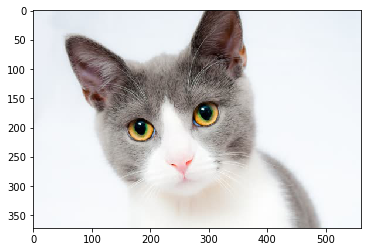

In [20]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [21]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
cat_tensor = torch.unsqueeze (cat_tensor, 0)
print (cat_tensor.size())
print (cat_tensor)

torch.Size([1, 3, 372, 560])
tensor([[[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

         [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

         [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.

### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [91]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())
print ('filter kernel :\n', filter_kernel)

torch.Size([3, 3, 3])
filter kernel :
 tensor([[[-1., -1., -1.],
         [-1.,  8., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1.,  8., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1.,  8., -1.],
         [-1., -1., -1.]]])


### Делаем свертку картинки ядром

changed x:
 tensor([[[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

         [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

         [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9

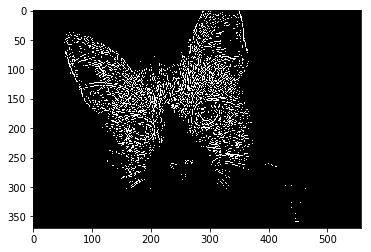

In [92]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image = torch.squeeze (o_image, 0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [93]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


changed x:
 tensor([[[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

         [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

         [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9

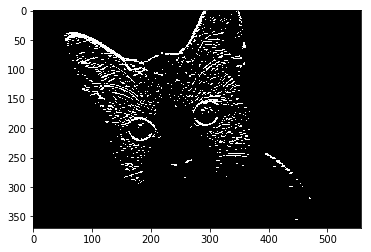

In [94]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image = torch.squeeze (o_image, 0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [95]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


changed x:
 tensor([[[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

         [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

         [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9

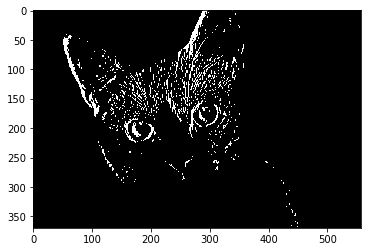

In [96]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image = torch.squeeze (o_image, 0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

changed x:
 tensor([[[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

         [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

         [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9

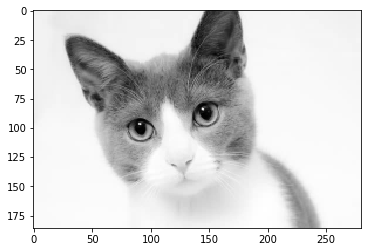

In [97]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем

o_image = torch.squeeze (o_image, 0)
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

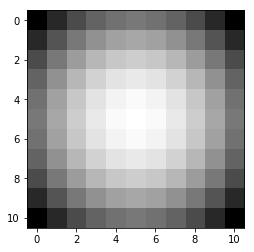

In [98]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

changed x:
 tensor([[[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

         [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
          [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

         [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
          [0.9569, 0.9569, 0.9

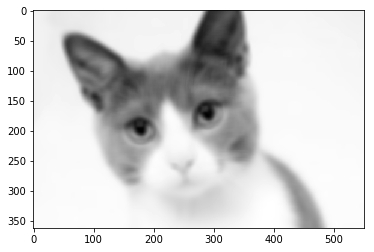

In [99]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
o_image = torch.squeeze (o_image, 0)
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} - (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} - (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- расширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [64]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        
        self.num_Features = in_channels
        self.affine    = afine
        self.momentum  = 1 - beta
        self.eps       = epsilon
        self.training  = False
        
        self.vt = 0
        self.st = 1
        self.iter = 0
        
        self.gamma = 0.7
        self.betta = 0.2
        
        self.running_mean = 0
        self.running_var  = 0
        
    def set_training (self, training = True):
        self.training = training
        
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        # находимся в режиме обучения
        #print ('x.size = ', x.size())
        mean = torch.mean (x, 2)
        mean = torch.mean (mean, 2)
        mean = torch.mean (mean, 0) 
        #print ('sizeof mean :', mean.size())
        #print ('mean :\n', mean)
        var  = torch.var  (x, 2)
        var  = torch.var  (var, 2)
        var  = torch.var  (var, 0)
        #print ('sizeof  var :', var.size())
        #print ( 'var.size = ', var.size(), '\nvar :\n', var)

        
        if self.training:            
            if (self.iter == 0):
                self.vt = mean
                self.st = var 
            else:
                self.vt = (1 - self.momentum) * self.vt + self.momentum * mean
                self.st = (1 - self.momentum) * self.st + self.momentum * var
                self.running_mean = torch.mean(self.vt)
                #print ('running_mean = ', self.running_mean)
                self.running_var  = torch.mean(self.st)
                #print ('running_var  = ', self.running_var)
        else:
            #self.vt = mean
            #self.st = var
            self.vt = torch.zeros(x.size())
            self.st = torch.ones (x.size()) 
            
            print ('vt :\n', self.vt.size())
                
                
        self.iter += 1
        if (self.affine == True):
            x = (x - self.vt) / torch.sqrt(self.st.add (self.eps)) * self.gamma + self.betta
        else:
            x = (x - self.vt) / torch.sqrt(self.st.add (self.eps))
        
        
        #print ('x :\n', x)
        #print ('self.eps = ', self.eps)
        return x
        
        

"""
a = torch.Tensor (7, 3, 5, 5)
for i in range (a.size(0)):
    a[i, :, :, :] = i
print ('a :\n', a)

bn = BatchNorm2d(3, afine=False)
b = bn.forward (a)
print ('b :\n', b)

for i in range (a.size(0)):
    a[i, :, :, :] = i + 100
b = bn.forward (a)
print ('b :\n', b)
""" 

"\na = torch.Tensor (7, 3, 5, 5)\nfor i in range (a.size(0)):\n    a[i, :, :, :] = i\nprint ('a :\n', a)\n\nbn = BatchNorm2d(3, afine=False)\nb = bn.forward (a)\nprint ('b :\n', b)\n\nfor i in range (a.size(0)):\n    a[i, :, :, :] = i + 100\nb = bn.forward (a)\nprint ('b :\n', b)\n"

### Проверяем работу батч нормадлизации на котэ

catTensor.size =  torch.Size([1, 3, 372, 560])
vt :
 torch.Size([1, 3, 372, 560])
o_image.size torch.Size([3, 372, 560])
torch.Size([3, 372, 560])


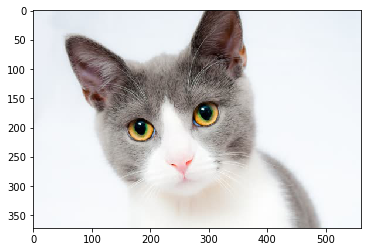

In [65]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
print ('catTensor.size = ', cat_tensor.size())
o_image = bn.forward(cat_tensor)

# убираем размерность батча
o_image = o_image.squeeze()
print ('o_image.size', o_image.size())
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

cat_tensor.size =  torch.Size([1, 3, 372, 560])
vt :
 torch.Size([1, 3, 372, 560])
torch.Size([3, 372, 560])


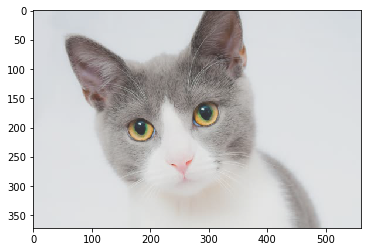

In [66]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
print ('cat_tensor.size = ', cat_tensor.size())
o_image = bn.forward(cat_tensor)
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [67]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [68]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


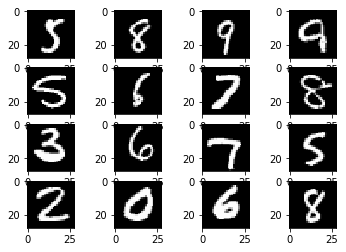

In [69]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [70]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.training = True
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        print ('nBatches = ', nbatches)
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            
            bn.forward(x)
            mean_curve += [ bn.running_mean ] 
            var_curve +=  [ bn.running_var  ]
    return mean_curve, var_curve

In [71]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.training = True
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

nBatches =  2187
nBatches =  2187
nBatches =  2187


Смотрим какие значения средних и дисперсий у нас получились

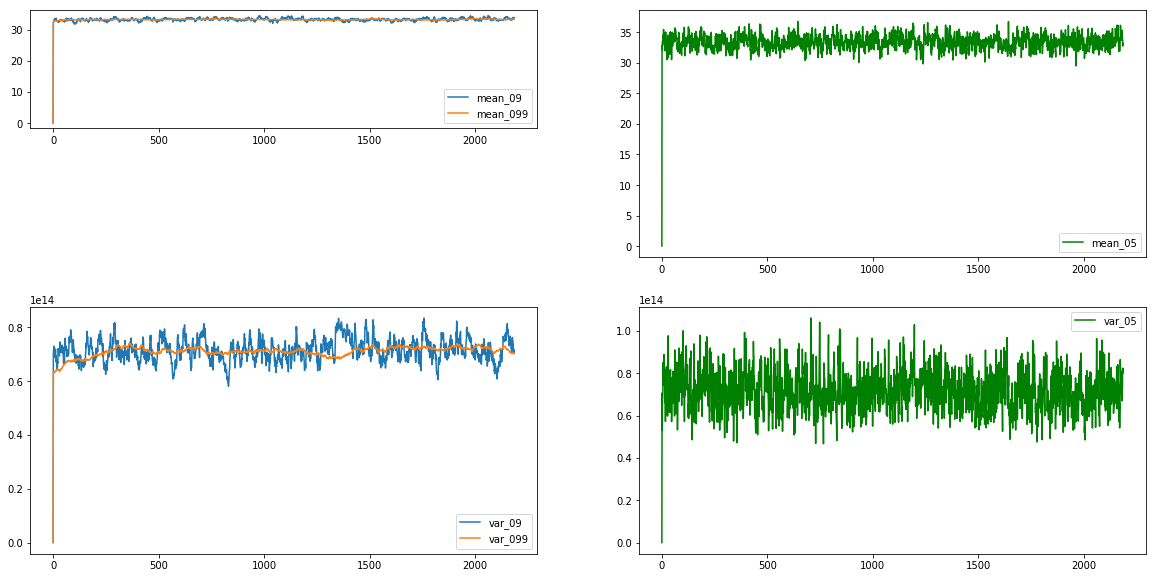

In [72]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])
vt :
 torch.Size([1, 28, 28])


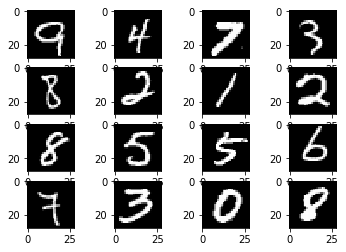

In [109]:
n=4
bn = bn_09
bn.training = False
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{1/2}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [4]:
import numpy as np
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

        
        
    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе 
            beta1, beta2 = group['betas'] # betas
            #print ('beta1 = ', beta1, 'beta2 = ', beta2)
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                #print ('p :\n', *p)
                
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                #print ('GRADIENT :\n-------------------------------------------------------------\n', grad)
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут хранятся значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]
                

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = grad # нужно проинициализировать TODO
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = grad * grad # нужно проинициализировать TODO
                    
                    step_size = lr
                
                else : 
                    state['step'] += 1
                    
                    state['avg'] = beta1 * state['avg'] + (1 - beta1) * grad
                    
                    state['avg_sq'] = beta2 * state['avg_sq'] + (1 - beta2) * grad * grad
                    
                    step_size = lr * (1 - beta2 ** state['step']) ** 0.5 / (1 - beta1 ** state['step'])
                # тут можем достать сохраненные состояния
                #exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                
                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                
                
                # обновляем веса в p.data, 
                # TODO
                
                p.data.addcdiv_ ( - step_size, state['avg'], torch.sqrt(state['avg_sq'].add(eps)))
                


        return loss

learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
optimizer.step()


NameError: name 'Net' is not defined

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [8]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        
        mt = None
        step = 0
        
        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                
                #print ('step = ', step)
                
                #if step == 0:
                #    mt = grad
                    
                
                #print ('mt :\n', mt)
                    
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    
                    
                    state = self.state[p]
                    if 'mt_buf' not in state:
                        state['mt_buf'] = grad
                    else:
                        state['mt_buf'] = beta * state['mt_buf'] + (1 - beta) * grad
                    
                    p.data.add_(- lr * state['mt_buf'])
                else :
                    p.data.add_(- lr * grad)
                    
                # обновляем веса
                # to do
                # p.data
                
                
                
                
                step += 1
        return 0


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [7]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [6]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24+2-3)/2+1 = 13, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [10]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward()# <-- тут расчитывается градиент
            #print ('loss ', loss)
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [14]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(30, net, optimizer) # обучаем сеть

/home/roma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11213397760000413
Do epoch 1 with loss 0.04729422699671986
Do epoch 2 with loss 0.037077460950730216
Do epoch 3 with loss 0.03097347942426644
Do epoch 4 with loss 0.02739763102495458
Do epoch 5 with loss 0.024105226824585574
Do epoch 6 with loss 0.021811241370033443
Do epoch 7 with loss 0.019593563286828625
Do epoch 8 with loss 0.01771957568984409
Do epoch 9 with loss 0.016360153635315663
Do epoch 10 with loss 0.015632322609124796
Do epoch 11 with loss 0.014193712019544244
Do epoch 12 with loss 0.012296590271010266
Do epoch 13 with loss 0.011833843291759709
Do epoch 14 with loss 0.010644841695627667
Do epoch 15 with loss 0.01014686499521729
Do epoch 16 with loss 0.008950229981172342
Do epoch 17 with loss 0.009526936316059558
Do epoch 18 with loss 0.009330424067496599
Do epoch 19 with loss 0.008792922643422536
Do epoch 20 with loss 0.006957672710117816
Do epoch 21 with loss 0.0062734722668687445
Do epoch 22 with loss 0.005435176858032028
Do epoch 23 with loss 0.00

## SGC с моментом

In [15]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(30, net, optimizer)

/home/roma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.295576294375627
Do epoch 1 with loss 0.059919993399510825
Do epoch 2 with loss 0.04447885747499863
Do epoch 3 with loss 0.038264144843961206
Do epoch 4 with loss 0.032312763308928225
Do epoch 5 with loss 0.029088507991950154
Do epoch 6 with loss 0.026072234031158766
Do epoch 7 with loss 0.023511270121605254
Do epoch 8 with loss 0.021565800988352566
Do epoch 9 with loss 0.01997067098291595
Do epoch 10 with loss 0.01883018280157609
Do epoch 11 with loss 0.01758990091347073
Do epoch 12 with loss 0.01595938304855663
Do epoch 13 with loss 0.014772574324884751
Do epoch 14 with loss 0.013723872537257521
Do epoch 15 with loss 0.013574580825051053
Do epoch 16 with loss 0.012606882550261803
Do epoch 17 with loss 0.011699284252697438
Do epoch 18 with loss 0.011233111771073143
Do epoch 19 with loss 0.010518499042380603
Do epoch 20 with loss 0.009171022241062152
Do epoch 21 with loss 0.008397222338580736
Do epoch 22 with loss 0.00835942309375326
Do epoch 23 with loss 0.007587

## Adam

In [11]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999)) # (0.9, 0.999)
loss_curve_adam = fit_net(30, net, optimizer)

/home/roma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.22428837574926425
Do epoch 1 with loss 0.04992195184733914
Do epoch 2 with loss 0.036988880623269965
Do epoch 3 with loss 0.03049581080920412
Do epoch 4 with loss 0.026594993818907307
Do epoch 5 with loss 0.023345808947827645
Do epoch 6 with loss 0.020166841056666312
Do epoch 7 with loss 0.01919282621235187
Do epoch 8 with loss 0.016274564492822403
Do epoch 9 with loss 0.015388358133974062
Do epoch 10 with loss 0.01344173612813182
Do epoch 11 with loss 0.01273765882019807
Do epoch 12 with loss 0.011222115974612687
Do epoch 13 with loss 0.010519853838650015
Do epoch 14 with loss 0.009618767055546143
Do epoch 15 with loss 0.008682402280922834
Do epoch 16 with loss 0.007941939008252285
Do epoch 17 with loss 0.009222012052374667
Do epoch 18 with loss 0.00762205499053601
Do epoch 19 with loss 0.007257294718893249
Do epoch 20 with loss 0.007422362570491184
Do epoch 21 with loss 0.006651377665653151
Do epoch 22 with loss 0.006352790974158918
Do epoch 23 with loss 0.0063

# Кривые обучения

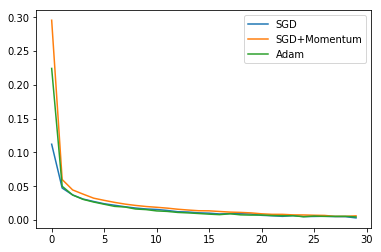

In [16]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()
#plt.ylim(0, 0.04)

(0, 0.04)

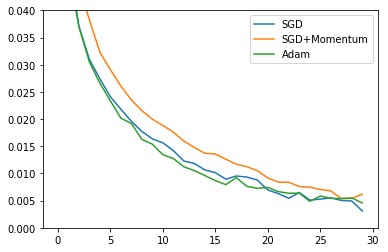

In [17]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()
plt.ylim(0, 0.04)

### Выводы

Колебания loss функции у "ADAM" меньше чем у "SGD" и "SGD + MOMENTUM", так же ее loss функция находится ниже => она сходится быстрее и эффективнее.